In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta, time
import copy
import re
from dataclasses import dataclass
from functools import lru_cache
from typing import List, Tuple
from alns import ALNS
from alns.accept import HillClimbing
from alns.select import SegmentedRouletteWheel
from alns.stop import MaxIterations

In [84]:
area_path = '../../dataset/area_work/'
path_to_facility= '../../dataset/facility_timing/'

### Load facilities

In [85]:
# Read visibility to facilites data
dfs = []
for path, subdirs, files in os.walk(path_to_facility):
    for name in files:
        if '.csv' in name:
            facility_csv_path = os.path.join(path, name)
            df = pd.read_csv(facility_csv_path, index_col=0)
            df['Start Time (UTCG)'] = pd.to_datetime(df['Start Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['Stop Time (UTCG)'] = pd.to_datetime(df['Stop Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            naming = name.split('-To-')
            df['facility'] = naming[0]
            sat_name = naming[1].split('.')[0]
            orbit_num = int(sat_name.split('_11')[1][:-2])
            if orbit_num > 5:
                sat_name = 'ZorkySat_' + sat_name.split('_')[1]
            df['sat_name'] = sat_name
            dfs.append(df)

facilities_df = pd.concat(dfs)

In [86]:
facilities_df = facilities_df.sort_values(by=['Start Time (UTCG)'])

### Filter within 2 days

In [16]:
# crop data from 2027-06-01 to 2027-06-02
# facilities_df = facilities_df[(facilities_df['Start Time (UTCG)'] > datetime(2027, 6, 1)) & (facilities_df['Start Time (UTCG)'] < datetime(2027, 6, 2))]

In [87]:
facilities_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),facility,sat_name
Acces,,,,,
1,2027-06-01 00:00:01.000,2027-06-01 00:08:57.612,536.612,Magadan1,KinoSat_110409
1,2027-06-01 00:00:01.000,2027-06-01 00:06:42.794,401.794,Norilsk,ZorkySat_111406
1,2027-06-01 00:00:01.000,2027-06-01 00:10:20.196,619.196,Novosib,ZorkySat_110908
1,2027-06-01 00:00:01.000,2027-06-01 00:01:47.395,106.395,Delhi,ZorkySat_111507
1,2027-06-01 00:00:01.000,2027-06-01 00:01:12.547,71.547,Moscow,ZorkySat_110710
...,...,...,...,...,...
144,2027-06-13 23:59:55.430,2027-06-14 00:00:01.000,5.570,Anadyr2,ZorkySat_111501
144,2027-06-13 23:59:55.430,2027-06-14 00:00:01.000,5.570,Anadyr1,ZorkySat_111501
157,2027-06-13 23:59:56.551,2027-06-14 00:00:01.000,4.449,Norilsk,ZorkySat_110605


### load area data

In [105]:
# Read area data
dfs = []
for path, subdirs, files in os.walk(area_path):
    for name in files:
        if '_' in name:
            area_csv_path = os.path.join(path, name)
            df = pd.read_csv(area_csv_path, index_col=0)
            df['Start Time (UTCG)'] = pd.to_datetime(df['Start Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['Stop Time (UTCG)'] = pd.to_datetime(df['Stop Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
            df['sat_name'] = name.split('.')[0]
            dfs.append(df)

area_df = pd.concat(dfs)

In [106]:
area_df = area_df.sort_values(by=['Start Time (UTCG)'])

In [107]:
area_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),sat_name
Acces,,,,
1,2027-06-01 03:00:00.000,2027-06-01 03:00:00.511,0.511,ZorkySat_111607
1,2027-06-01 03:00:00.000,2027-06-01 03:02:15.836,135.836,ZorkySat_111806
1,2027-06-01 03:00:00.000,2027-06-01 03:00:18.248,18.248,ZorkySat_111008
1,2027-06-01 03:00:00.000,2027-06-01 03:01:14.388,74.388,KinoSat_110202
1,2027-06-01 03:00:00.000,2027-06-01 03:01:51.331,111.331,ZorkySat_111109
...,...,...,...,...
104,2027-06-13 11:57:29.838,2027-06-13 12:00:00.000,150.162,ZorkySat_111007
115,2027-06-13 11:58:24.078,2027-06-13 12:00:00.000,95.922,ZorkySat_111704
116,2027-06-13 11:59:16.297,2027-06-13 12:00:00.000,43.703,ZorkySat_111903


### Select period with onw work cycle

In [108]:
lower_bound = area_df['Start Time (UTCG)'].min()
upper_bound = area_df[area_df['Start Time (UTCG)'] > datetime(2027, 6, 2)]['Start Time (UTCG)'].min()

In [109]:
lower_bound

Timestamp('2027-06-01 03:00:00')

### Filter within 2 days

In [110]:
# crop data from 2027-06-01 to 2027-06-02
area_df = area_df[(area_df['Start Time (UTCG)'] >= lower_bound) & (area_df['Start Time (UTCG)'] < upper_bound)]

In [111]:
facilities_df = facilities_df[(facilities_df['Start Time (UTCG)'] > lower_bound) & (facilities_df['Start Time (UTCG)'] < upper_bound)]

In [112]:
#calculate data filmed by sat (4Gbit/sec) in Tbytes
area_df['Data'] = area_df['Duration (sec)'] * 4 / 8192

/var/folders/jw/yxnqr82j48z086z2gxyv80nc0000gn/T/ipykernel_1017/3024178886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  area_df['Data'] = area_df['Duration (sec)'] * 4 / 8192


In [115]:
area_df

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),sat_name,Data
Acces,,,,,
1,2027-06-01 03:00:00.000,2027-06-01 03:00:00.511,0.511,ZorkySat_111607,0.000250
1,2027-06-01 03:00:00.000,2027-06-01 03:02:15.836,135.836,ZorkySat_111806,0.066326
1,2027-06-01 03:00:00.000,2027-06-01 03:00:18.248,18.248,ZorkySat_111008,0.008910
1,2027-06-01 03:00:00.000,2027-06-01 03:01:14.388,74.388,KinoSat_110202,0.036322
1,2027-06-01 03:00:00.000,2027-06-01 03:01:51.331,111.331,ZorkySat_111109,0.054361
...,...,...,...,...,...
9,2027-06-01 11:57:04.719,2027-06-01 12:00:00.000,175.281,ZorkySat_111002,0.085586
8,2027-06-01 11:57:59.303,2027-06-01 12:00:00.000,120.697,ZorkySat_111709,0.058934
11,2027-06-01 11:58:49.194,2027-06-01 12:00:00.000,70.806,ZorkySat_111908,0.034573


### Cut area used from fac vis

In [116]:
sat_names = area_df['sat_name'].unique()
dfs = []
i = 0
for sat_name in sat_names:
    i += 1
    print(f'{i}/{len(sat_names)} - {sat_name}')
    area_df_sat = area_df[area_df['sat_name'] == sat_name]
    facilities_df_sat = facilities_df[facilities_df['sat_name'] == sat_name]
    filtered_facilities_df = facilities_df_sat.copy()
    for _, area_row in area_df_sat.iterrows():
        cut_start = area_row['Start Time (UTCG)']
        cut_stop = area_row['Stop Time (UTCG)']
        new_df = pd.DataFrame(columns=filtered_facilities_df.columns)
        for index, facility_row in filtered_facilities_df.iterrows():
            start_time_facility = facility_row['Start Time (UTCG)']
            stop_time_facility = facility_row['Stop Time (UTCG)']
            if max(cut_start, start_time_facility) < min(cut_stop, stop_time_facility):
                alt_row = facility_row.copy()
                if start_time_facility < cut_start:
                    facility_row['Stop Time (UTCG)'] = cut_start
                    new_df = pd.concat([new_df, facility_row.to_frame(1).T], ignore_index=True)
                if stop_time_facility > cut_stop:
                    alt_row['Start Time (UTCG)'] = cut_stop
                    new_df = pd.concat([new_df, alt_row.to_frame(1).T], ignore_index=True)
            else:
                new_df = pd.concat([new_df, facility_row.to_frame(1).T], ignore_index=True)
        filtered_facilities_df = new_df.copy()
    dfs.append(filtered_facilities_df)

facilities_df_no_area = pd.concat(dfs)

1/200 - ZorkySat_111607
2/200 - ZorkySat_111806
3/200 - ZorkySat_111008
4/200 - KinoSat_110202
5/200 - ZorkySat_111109
6/200 - ZorkySat_111706
7/200 - ZorkySat_112005
8/200 - ZorkySat_111507
9/200 - ZorkySat_111308
10/200 - KinoSat_110301
11/200 - KinoSat_110102
12/200 - KinoSat_110510
13/200 - ZorkySat_111905
14/200 - ZorkySat_111009
15/200 - ZorkySat_110709
16/200 - ZorkySat_110908
17/200 - ZorkySat_111208
18/200 - KinoSat_110410
19/200 - ZorkySat_111407
20/200 - ZorkySat_110609
21/200 - KinoSat_110201
22/200 - ZorkySat_111606
23/200 - ZorkySat_111805
24/200 - ZorkySat_110909
25/200 - KinoSat_110310
26/200 - ZorkySat_110808
27/200 - ZorkySat_112004
28/200 - ZorkySat_111108
29/200 - ZorkySat_111307
30/200 - KinoSat_110101
31/200 - ZorkySat_111007
32/200 - ZorkySat_111506
33/200 - ZorkySat_111705
34/200 - ZorkySat_110708
35/200 - KinoSat_110509
36/200 - ZorkySat_111904
37/200 - KinoSat_110409
38/200 - ZorkySat_110907
39/200 - ZorkySat_111207
40/200 - KinoSat_110210
41/200 - ZorkySat_11

In [117]:
facilities_df_no_area.reset_index(inplace=True, drop=True)

In [118]:
test_df = facilities_df_no_area.copy()
test_df['Duration (sec)'] = (test_df['Stop Time (UTCG)'] - test_df['Start Time (UTCG)']).dt.total_seconds()

In [119]:
final_no_aree_facilities_df = test_df.copy()

In [120]:
df_fac_to_plot = final_no_aree_facilities_df[final_no_aree_facilities_df['facility'] == 'Anadyr1']

In [122]:
df_fac_to_plot = df_fac_to_plot.sort_values(by=['Start Time (UTCG)'])
df_fac_to_plot['sat_name'].unique()

200

In [126]:
df_fac_to_plot = df_fac_to_plot.sort_values(by=['sat_name'])

In [127]:
df_fac_to_plot

,Start Time (UTCG),Stop Time (UTCG),Duration (sec),facility,sat_name
4353,2027-06-02 00:05:17.250,2027-06-02 00:16:19.668,662.418,Anadyr1,KinoSat_110101
4332,2027-06-01 20:52:16.958,2027-06-01 21:04:39.089,742.131,Anadyr1,KinoSat_110101
4320,2027-06-01 19:18:25.380,2027-06-01 19:28:54.797,629.417,Anadyr1,KinoSat_110101
4342,2027-06-01 22:27:41.222,2027-06-01 22:40:34.538,773.316,Anadyr1,KinoSat_110101
4277,2027-06-01 09:48:23.799,2027-06-01 09:58:38.426,614.627,Anadyr1,KinoSat_110101
...,...,...,...,...,...
16236,2027-06-02 00:38:54.281,2027-06-02 00:49:00.919,606.638,Anadyr1,ZorkySat_112010
16103,2027-06-01 03:35:49.668,2027-06-01 03:44:43.401,533.733,Anadyr1,ZorkySat_112010
16171,2027-06-01 09:57:13.107,2027-06-01 10:01:11.703,238.596,Anadyr1,ZorkySat_112010
16154,2027-06-01 08:27:45.783,2027-06-01 08:31:47.183,241.400,Anadyr1,ZorkySat_112010


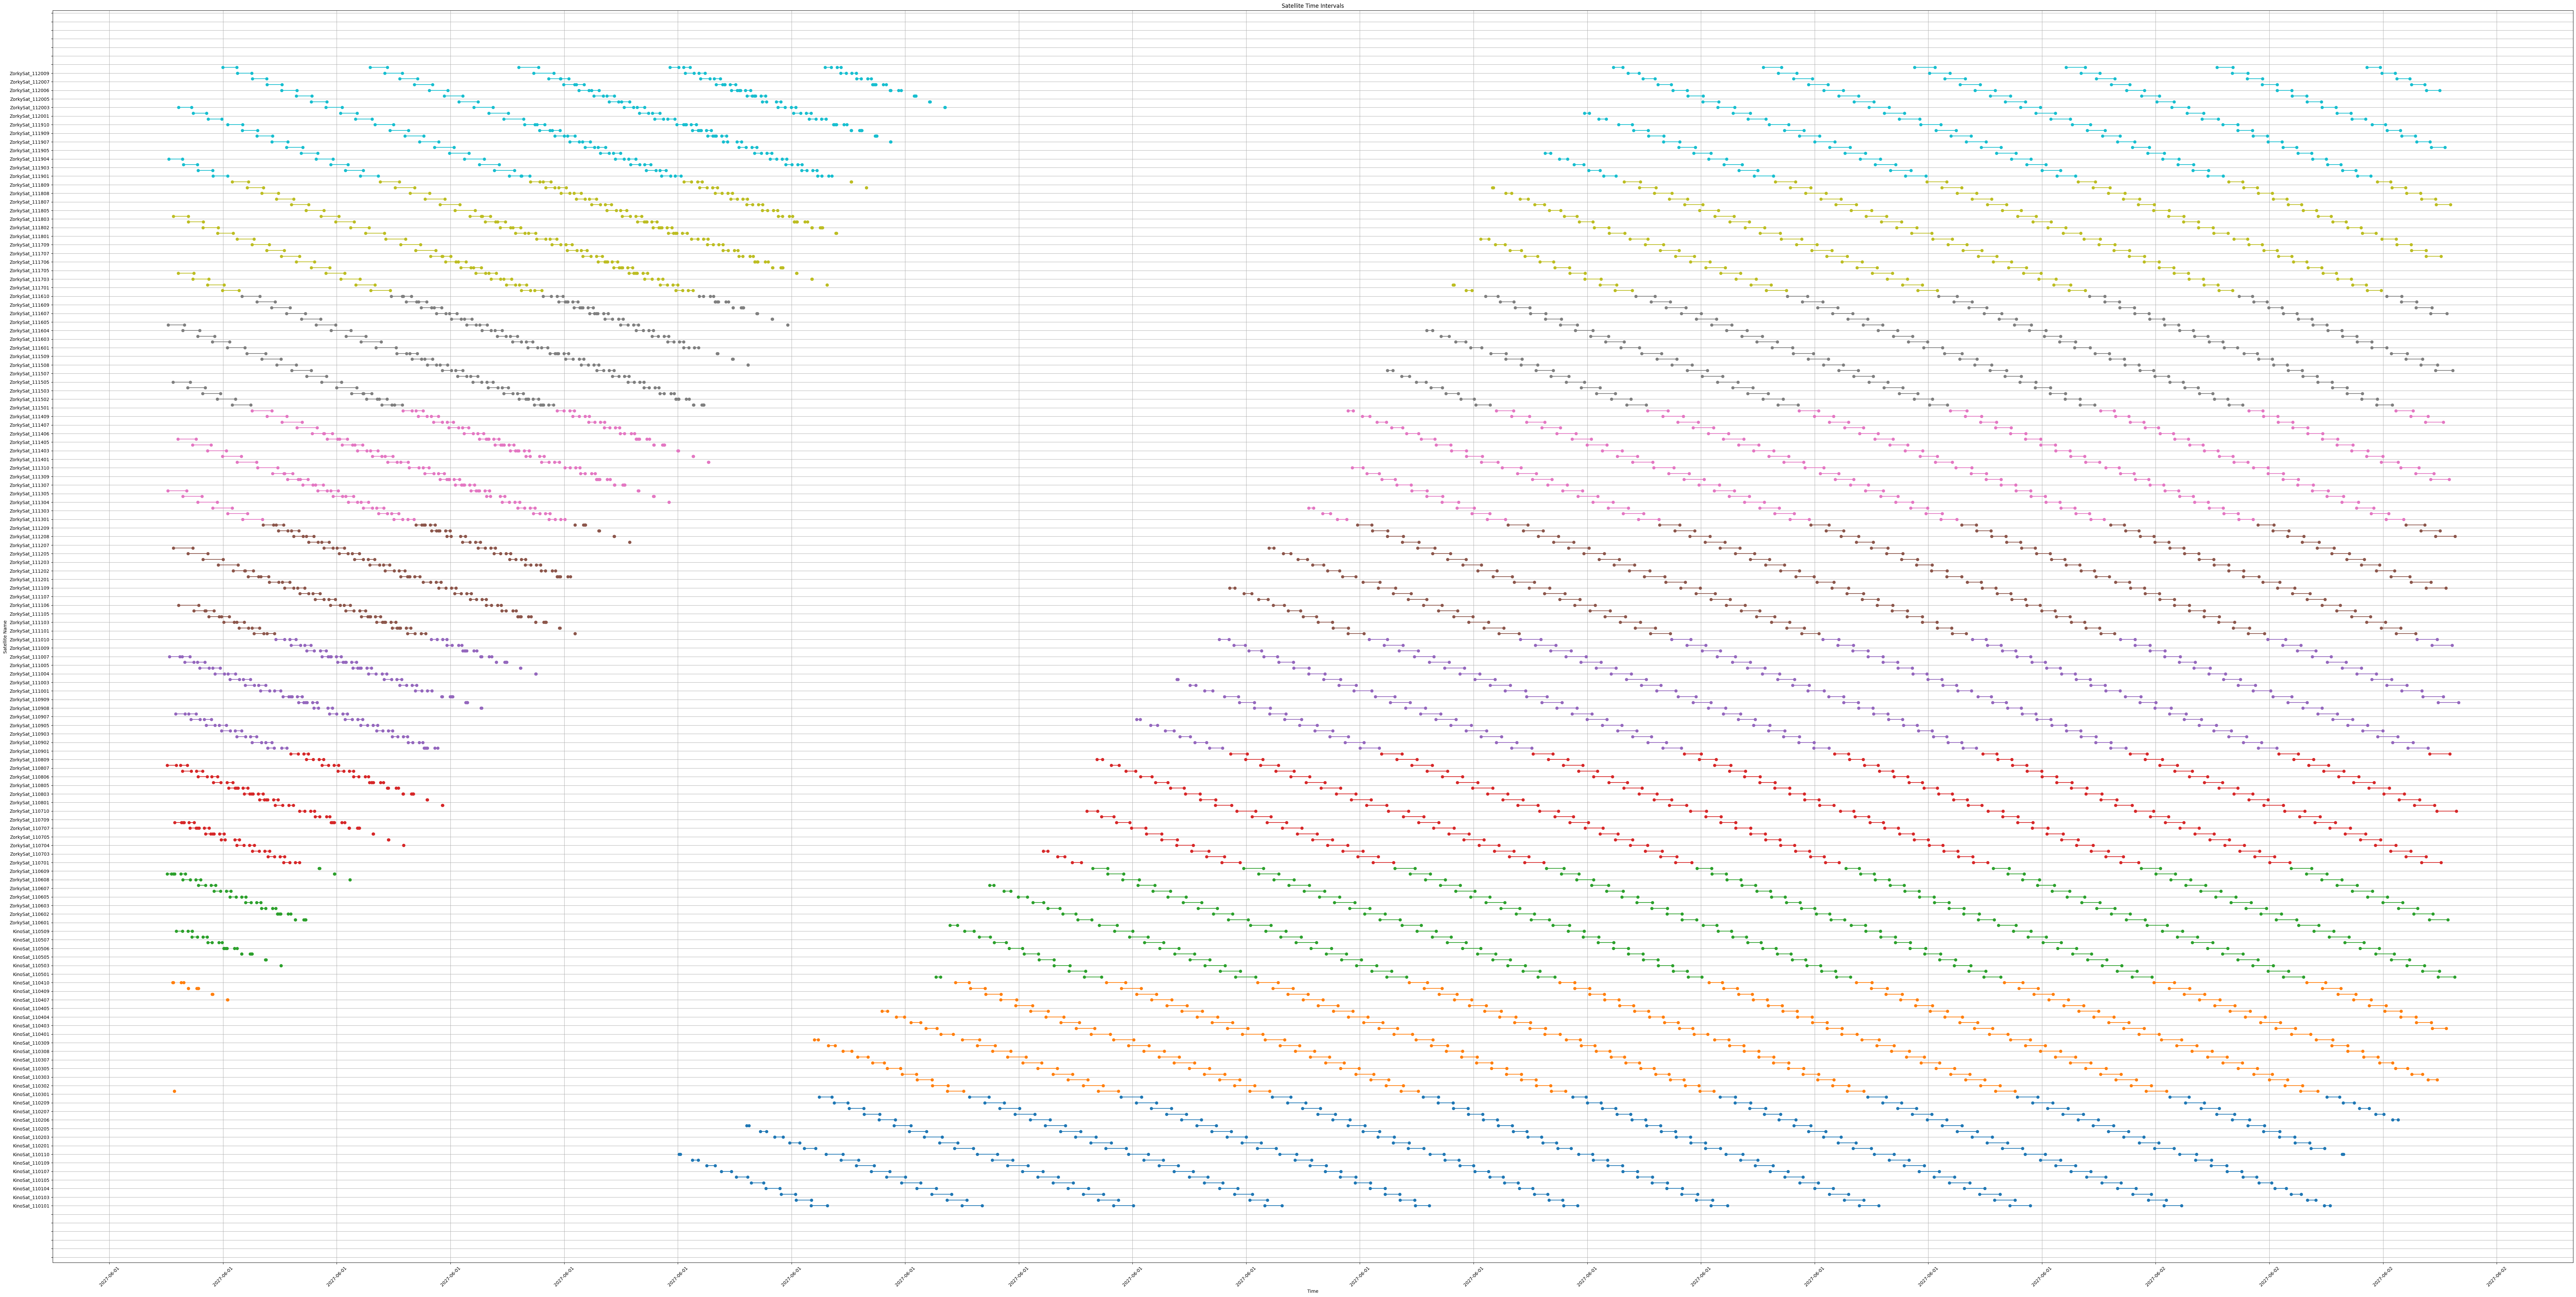

In [128]:
# Set the figure size
plt.figure(figsize=(100, 50))

colors = plt.cm.tab10(np.linspace(0, 1, 10))


# Get unique satellite names
unique_sat_names = df_fac_to_plot['sat_name'].unique()

# Create a colormap with a unique color for each satellite name
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sat_names)))

# Plot the time intervals as a line plot with unique colors
for i, row in df_fac_to_plot.iterrows():
    sat_name = row['sat_name']
    color = colors[np.where(unique_sat_names == sat_name)[0][0]]
    plt.plot([row['Start Time (UTCG)'], row['Stop Time (UTCG)']], [sat_name, sat_name], marker='o', color=color)

# Set the y-axis labels as satellite names
plt.yticks(unique_sat_names)

# Set x-axis and y-axis labels
plt.xlabel('Time')
plt.ylabel('Satellite Name')

# Set the title of the plot
plt.title('Satellite Time Intervals')

# Increase tick rate on x-axis
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=24))

# Increase tick rate on y-axis
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=len(unique_sat_names)))

# insert grid lines
plt.grid()

# Display the plot
plt.show()

### setup dataRepr

In [129]:
@dataclass(frozen=True)
class ProblemData:
    visibility_slots: List[List[List[Tuple[datetime, datetime]]]] # [facility][sat][slots][start, end]
    data_filmed_by_sat: List[List[Tuple[datetime, float]]] # [sat][slots][due_date, data]
    facilities_name_to_num: dict
    sat_name_to_num: dict
    zorky_data_downlink = 0.25
    zorky_data_capacity = 0.5

    kinosat_data_downlink = 1.0
    kinosat_data_capacity = 1.0

    def __hash__(self) -> int:
        return id(self)
    @classmethod
    def read_data(cls, facilities_df: pd.DataFrame, area_df: pd.DataFrame):
        # parse facilities df to visibility slots
        facilities_name = facilities_df['facility'].unique()
        # encode facilities witn numbers
        facilities_name_to_num = {name: i for i, name in enumerate(facilities_name)}

        # parse area df to data filmed by sat
        sat_names = area_df['sat_name'].unique()
        sat_names = sorted(sat_names)
        # encode sat names with numbers
        sat_name_to_num = {name: i for i, name in enumerate(sat_names)}
        data_filmed_by_sat = []
        for sat_name in sat_names:
            sat_df = area_df[area_df['sat_name'] == sat_name]
            data_filmed_by_sat.append(list(zip(sat_df['Stop Time (UTCG)'], sat_df['Data'])))

        # iterate over facilities
        visibility_slots = []
        for facility_name in facilities_name:
            facility_df = facilities_df[facilities_df['facility'] == facility_name]
            sat_visibility = []
            for sat_name in sat_names:
                sat_df = facility_df[facility_df['sat_name'] == sat_name]
                sat_visibility.append(list(zip(sat_df['Start Time (UTCG)'], sat_df['Stop Time (UTCG)'])))
            visibility_slots.append(sat_visibility)

        return cls(visibility_slots, data_filmed_by_sat, facilities_name_to_num, sat_name_to_num)


In [130]:
instance = ProblemData.read_data(final_no_aree_facilities_df, area_df)

In [ ]:
class SIDSPState:
    def __init__(self, sessions: List[Tuple[int]]) -> None:
        self.sessions = sessions

    def __copy__(self):
        return SIDSPState(self.sessions.copy())
